# 설치

In [1]:
! pip install Korpora
! pip install tokenizers
! pip install transformers[sentencepiece]
! pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# dataset download(뉴스기사)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os
import json
# 정답 추출
news_json1 = open('/content/drive/MyDrive/Colab Notebooks/데이터사이언스 특론/term project/017.뉴스 기사 기계독해 데이터/01.데이터/1.Training/라벨링데이터/news_QnA/TL_span_extraction.json', encoding = 'utf-8')

news_dict = json.load(news_json1)

# data preprocessing

In [4]:
sentence_list = []
for data in news_dict['data']:
  context = data['paragraphs'][0]['context']
  context_list = context.replace('\n','').split('.')
  sentence_list.extend(context_list)

In [6]:
import pandas as pd
df = pd.DataFrame()
df['sentence'] = sentence_list

def strip(x):
  return x.strip()

df['sentence'] = df.sentence.apply(strip)
df = df[:100000]
df.head()

,sentence
0,익산시 서부권역 다목적 체육관이 내달 개관을 앞두고 막바지 개관 준비가 한창이다
1,시에 따르면 시민들의 건강증진과 삶의 질 향상을 위한 생활체육 인프라 확충 등을 위...
2,"전문 체육시설인 서부권역 다목적 체육관은 지하 1층과 지상 3층, 연면적 4719㎡..."
3,"수영장 6개 레인과 어린이풀장, 다목적실(에어로빅, 요가 등), 체력단련실, 어르신..."
4,첫 번째로 개관되는 시설은 헬스장이다


## BPE tokenizer

In [6]:
with open('/content/drive/MyDrive/Colab Notebooks/논문구현/news.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(df['sentence']))

In [ ]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer(
    add_prefix_space = True,
    lowercase = False)

In [ ]:
data_file = '/content/drive/MyDrive/Colab Notebooks/논문구현/news.txt'
vocab_size = 40000
min_frequency = 5

tokenizer.train(
    files = data_file,
    vocab_size = vocab_size,
    min_frequency = min_frequency)

In [ ]:
tokenizer.add_special_tokens(['[EOS]', '[BOS]', '[PAD]'])

3

In [ ]:
tokenizer.save_model('/content/drive/MyDrive/Colab Notebooks/논문구현/')

['/content/drive/MyDrive/Colab Notebooks/논문구현/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/논문구현/merges.txt']

In [7]:
from tokenizers import ByteLevelBPETokenizer

# 불러오기
vocab = '/content/drive/MyDrive/Colab Notebooks/논문구현/vocab.json'
merges = '/content/drive/MyDrive/Colab Notebooks/논문구현/merges.txt'

bpe_tokenizer = ByteLevelBPETokenizer(
    vocab = vocab,
    merges = merges)

In [8]:
bpe_tokenizer.add_special_tokens(['[EOS]', '[BOS]', '[PAD]'])

3

## dataset

In [9]:
# index id
def index_tokens(sentence, tokenizer):
  return tokenizer.encode(sentence).ids

def get_special_tokens(x):
  return '[BOS] ' + x + ' [EOS]'

def length(x):
  return len(x)

df['sentence'] = df.sentence.apply(get_special_tokens)
df['index_tokens'] = df.sentence.apply(lambda x : index_tokens(x, bpe_tokenizer))
df['length'] = df.index_tokens.apply(length)
df.head()

,sentence,index_tokens,length
0,[BOS] 익산시 서부권역 다목적 체육관이 내달 개관을 앞두고 막바지 개관 준비가 ...,"[40001, 7317, 6662, 8164, 10033, 3128, 3191, 6...",16
1,[BOS] 시에 따르면 시민들의 건강증진과 삶의 질 향상을 위한 생활체육 인프라 확...,"[40001, 4460, 1053, 3522, 34404, 4121, 1385, 5...",36
2,"[BOS] 전문 체육시설인 서부권역 다목적 체육관은 지하 1층과 지상 3층, 연면적...","[40001, 1152, 3128, 12119, 6662, 8164, 10033, ...",30
3,"[BOS] 수영장 6개 레인과 어린이풀장, 다목적실(에어로빅, 요가 등), 체력단련...","[40001, 22938, 660, 484, 1935, 3237, 1908, 582...",57
4,[BOS] 첫 번째로 개관되는 시설은 헬스장이다 [EOS],"[40001, 1188, 8647, 7082, 990, 13830, 23585, 4...",10


Text(0, 0.5, 'count')

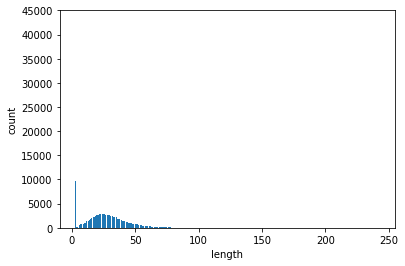

In [10]:
import matplotlib.pyplot as plt

index = df.length.value_counts().sort_index().index
value = df.length.value_counts().sort_index().values

plt.figure()
plt.bar(index, value)
plt.ylim([0,45000])
plt.xlabel('length')
plt.ylabel('count')

In [11]:
# position id
def position_tokens(token_list, max_length):
  position = [i for i in range(max_length)]
  return position

def get_pad(x, max_length, tokenizer):
  if len(x) < max_length:
    return x + tokenizer.encode('[PAD]').ids*(max_length-len(x))
  else:
    return x

def target_processing(x, tokenizer):
  return x[1:] + tokenizer.encode('[PAD]').ids

In [12]:
from torch.utils.data import Dataset

class GPTDataset(Dataset):
    def __init__(self, data, max_length, tokenizer):
      self.GPT_data = data.loc[(data.length >= 15) & (data.length <= max_length)]
      self.token = self.GPT_data.index_tokens.to_list()
      self.token_ids = [get_pad(x, max_length, tokenizer) for x in self.token]
      self.position_ids = [position_tokens(x, max_length) for x in self.token]
      self.label = [target_processing(x, tokenizer) for x in self.token_ids]


    def __len__(self):
      return len(self.token_ids)

    def __getitem__(self, idx):
      return [self.token_ids[idx],   # 실제 token id  
              self.position_ids[idx],   # 위치 값
              self.label[idx]]


In [13]:
gpt_data = GPTDataset(df, 150, bpe_tokenizer)

In [14]:
len(gpt_data)

80469

# dataloader

In [15]:
from torch.utils.data import DataLoader
from torch import nn
import torch

def collate_fn(batch):
  token_id = torch.tensor([b[0] for b in batch])
  position_ids =torch.tensor([b[1] for b in batch])
  label = torch.tensor([b[2] for b in batch])
  return  token_id, position_ids, label

input_dataloader = DataLoader(gpt_data, collate_fn=collate_fn, batch_size=32)

In [16]:
next(iter(input_dataloader))

(tensor([[40001,  7317,  6662,  ..., 40002, 40002, 40002],
         [40001,  4460,  1053,  ..., 40002, 40002, 40002],
         [40001,  1152,  3128,  ..., 40002, 40002, 40002],
         ...,
         [40001,  2538,  3540,  ..., 40002, 40002, 40002],
         [40001, 10835, 34318,  ..., 40002, 40002, 40002],
         [40001,  1683,  9179,  ..., 40002, 40002, 40002]]),
 tensor([[  0,   1,   2,  ..., 147, 148, 149],
         [  0,   1,   2,  ..., 147, 148, 149],
         [  0,   1,   2,  ..., 147, 148, 149],
         ...,
         [  0,   1,   2,  ..., 147, 148, 149],
         [  0,   1,   2,  ..., 147, 148, 149],
         [  0,   1,   2,  ..., 147, 148, 149]]),
 tensor([[ 7317,  6662,  8164,  ..., 40002, 40002, 40002],
         [ 4460,  1053,  3522,  ..., 40002, 40002, 40002],
         [ 1152,  3128, 12119,  ..., 40002, 40002, 40002],
         ...,
         [ 2538,  3540, 10835,  ..., 40002, 40002, 40002],
         [10835, 34318,  3570,  ..., 40002, 40002, 40002],
         [ 1683,  9179,

# Model

## scaled dot product


In [17]:
class scaled_dot_product(nn.Module):
  def __init__(self):
    super(scaled_dot_product, self).__init__()
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, query, key, value, mask, masked):
    key_tr = torch.transpose(key, 2, 3)
    dk = torch.tensor(query.size()[-1])
    outputs = (query @ key_tr) / dk.sqrt()

    if mask is not None:
      outputs = outputs.masked_fill(mask == 0, -2**30)

    if masked:
      mask1 = torch.ones_like(outputs[:,:,:])
      mask1 = torch.triu(mask1, diagonal=1)
      mask1 = mask1*(-2**30)
      padding = torch.ones_like(mask1)
      padding = torch.tril(padding)
      outputs = torch.where(padding==1, outputs, mask1)

    attention_map = self.softmax(outputs)
    scaled_dp = (attention_map @ value)
    return scaled_dp, attention_map

## multihead attention

In [18]:
class multihead_attention(nn.Module):
  def __init__(self, embedding_dims, model_dims, num_heads):
    super(multihead_attention, self).__init__()

    self.num_heads = num_heads
    self.linear_q = nn.Linear(embedding_dims, model_dims)
    self.linear_k = nn.Linear(embedding_dims, model_dims)
    self.linear_v = nn.Linear(embedding_dims, model_dims)
    self.linear_output = nn.Linear(model_dims, model_dims)
    self.attention = scaled_dot_product()

  def split(self, tensor):
    batch_size, sequence_length, d_model = tensor.size()

    d_tensor = d_model // self.num_heads
    tensor = tensor.view(batch_size, sequence_length, self.num_heads, d_tensor).transpose(1, 2)
    return tensor

  def cat(self, tensor):
    batch_size, self.num_heads, sequence_length, d_tensor = tensor.size()
    d_model = self.num_heads * d_tensor

    tensor = tensor.transpose(1, 2).contiguous().view(batch_size, sequence_length, d_model)
    return tensor

  def forward(self, query, key, value, mask, masked):
    query1 = self.linear_q(query)
    key1 = self.linear_k(key)
    value1 = self.linear_v(value)

    query_split = self.split(query1)
    key_split = self.split(key1)
    value_split = self.split(value1)

    multihead_attn, attn_map = self.attention(query_split, key_split, value_split, mask, masked)
    attn_outputs1 = self.cat(multihead_attn)
    attn_outputs2 = self.linear_output(attn_outputs1)
    return attn_outputs2

## feed forward 

In [19]:
class feed_forward(nn.Module):
  def __init__(self, model_dims, ff_dims):
    super(feed_forward, self).__init__()
    self.dropout_p = 0.1
    self.linear_inner = nn.Linear(model_dims, ff_dims)
    self.linear_outer = nn.Linear(ff_dims, model_dims)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=self.dropout_p)

  def forward(self, input):
    output1 = self.linear_inner(input)
    output2 = self.relu(output1)
    output3 = self.dropout(output2)
    output4 = self.linear_outer(output3)
    return output4


## layer norm

In [20]:
class layer_norm(nn.Module):
  def __init__(self, model_dims, eps=1e-6):
    super(layer_norm, self).__init__()
    self.layernorm = nn.LayerNorm(model_dims)

  def forward(self, input):
    output = self.layernorm(input)
    return output

## sublayer connection

In [21]:
class sublayer_connection(nn.Module):
  def __init__(self, model_dims, dropout_p):
    super(sublayer_connection, self).__init__()
    self.layernorm = layer_norm(model_dims)
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, input, output):
    outputs = self.layernorm(input + self.dropout(output))
    return outputs

## decoder module

In [22]:
class decoder_module(nn.Module):
  def __init__(self, model_dims, ff_dims, dropout_p, embedding_dims, num_heads):
    super(decoder_module, self).__init__()
    self.multiheadattention_de = multihead_attention(embedding_dims, model_dims, num_heads)
    self.feedforward = feed_forward(model_dims, ff_dims)
    self.sublayerconnection1 = sublayer_connection(model_dims, dropout_p)
    self.sublayerconnection2 = sublayer_connection(model_dims, dropout_p)

  def forward(self, decoder_inputs, mask):
    masked_multihead_attn = self.sublayerconnection1(decoder_inputs, self.multiheadattention_de(decoder_inputs, decoder_inputs, decoder_inputs, mask, masked=True)) # self attention 
    outputs1 = self.sublayerconnection2(masked_multihead_attn, self.feedforward(masked_multihead_attn))
    return outputs1

## decoder

In [23]:
class decoder(nn.Module):
  def __init__(self, model_dims, ff_dims, num_heads, num_layers, embedding_dims, len_vocab, dropout_p, max_length):
    super(decoder, self).__init__()
    self.embedding_token = nn.Embedding(len_vocab, embedding_dims)
    self.embedding_position = nn.Embedding(max_length, embedding_dims)
    self.last_linear = nn.Linear(model_dims, len_vocab)
    self.decoder_layer = nn.ModuleList([decoder_module(model_dims = model_dims,
                                                       ff_dims = ff_dims,
                                                       num_heads = num_heads,
                                                       dropout_p=dropout_p,
                                                       embedding_dims = embedding_dims)
                                        for _ in range(num_layers)])
    
  def forward(self, decoder_inputs, position, mask):
    decoder_embedding = self.embedding_token(decoder_inputs) + self.embedding_position(position)
    outputs = decoder_embedding
    for layer in self.decoder_layer:
      outputs = layer(outputs, mask)
    outputs1 = self.last_linear(outputs)
    return outputs1

## GPT

In [24]:
class GPT(nn.Module):
  def __init__(self, model_dims, ff_dims, num_heads, num_layers, embedding_dims, len_vocab, dropout_p, src_pad_idx, max_length):
    super(GPT, self).__init__()
    self.src_pad_idx = src_pad_idx
    self.decoder = decoder(model_dims, ff_dims, num_heads, num_layers, embedding_dims, len_vocab, dropout_p, max_length)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, decoder_inputs, position):
    decoder_mask = self.make_pad_mask(decoder_inputs, decoder_inputs)
    decoder_outputs = self.decoder(decoder_inputs, position, decoder_mask)
    return decoder_outputs

  def make_pad_mask(self,q,k):
    len_q,len_k = q.size(1),k.size(1)
    k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    k = k.repeat(1,1,len_q,1)
    q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
    q = q.repeat(1,1,1,len_k)
    mask = k & q
    return mask


# train

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [26]:
# model_dims, ff_dims, num_heads, num_layers, embedding_dims, len_vocab, dropout_p, src_pad_idx, max_length
gpt_model = GPT(512, 1024, 8, 6, 512, 40000+4, 0.1, 40002, 150).to(device)

In [27]:
epochs = 5
lr = 0.0001
optimizer = torch.optim.Adam(gpt_model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=40002)

In [28]:
def train(model, optimizer, criterion, dataloader):
  losses = [] 
  for i, data in enumerate(dataloader):
    optimizer.zero_grad()

    token_ids, position_ids, label = data

    token_ids = token_ids.to(device)
    position_ids = position_ids.to(device)
    label = label.to(device)

    gpt_logits = model(token_ids, position_ids)
    loss = criterion(gpt_logits.transpose(1,2), label)

    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
  return sum(losses) / len(losses)



In [29]:
for i in range(epochs):
  avg_loss = train(gpt_model, optimizer, criterion, input_dataloader)
  print('epoch = ', i, ' avg_loss = ', avg_loss)

epoch =  0  avg_loss =  8.44289943020102
epoch =  1  avg_loss =  8.392536951865164
epoch =  2  avg_loss =  8.449463051972286
epoch =  3  avg_loss =  8.334182672329973
epoch =  4  avg_loss =  8.126748457959822
